In [1]:
import numpy as np
import os
import pickle
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image

import tensorflow.keras as keras

2025-01-28 18:30:21.137726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 18:30:21.147255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738078221.157595   22656 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738078221.160786   22656 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 18:30:21.172425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report


import skimage.io
from scipy.spatial.distance import cdist

import sys
sys.path.insert(0,'../')
from helper import classification_tools as ct
from helper import visualize as vis

%matplotlib inline

In [3]:
# fc1 features saved from the previous step
fc1_path = Path('..','data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

# label encoder model which converts string labels to integers.
le_path = Path('..','models','label_encoder.pickle')
assert le_path.is_file()

# load the data and label encoder into memory
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)

In [4]:
files = data['filename']  # file paths to each image
fc1 = data['features']  # array containing fc1 features for each file
labels = data['labels']  # string labels for each image
y_gt = le.transform(labels)  # integer labels for each image

In [5]:
# Paths to pre-trained models
pca_path = "../models/pca_fit_base.pickle"
kmeans_path = "../models/kmeans_labeled_base.pickle"
encoder_path = "../models/label_encoder.pickle"

In [6]:
vgg16_path = Path('..','models','VGG16.h5')
if not vgg16_path.is_file():
    vgg16 = keras.applications.VGG16(include_top=True,  # include fully connected layers
                                     weights='imagenet') # use pre-trained model
    vgg16.save(vgg16_path) # save model so we don't have to download it everytime
    
else:   
    vgg16 = keras.models.load_model(vgg16_path) # use saved model

I0000 00:00:1738078222.388009   22656 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
import os
import pickle
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

################################
#  Suppose you already loaded:
#  fc1 -> shape (N, 4096)
#  labels, etc.
################################

# (A) Fit PCA to go from 4096 -> 50 dimensions
pca = PCA(n_components=50, whiten=True, svd_solver='full')
X_50 = pca.fit_transform(fc1)  # shape => (N, 50)

# (B) Fit KMeans on these 50-D vectors
kmeans_50d = KMeans(n_clusters=6, random_state=42, n_init=500)
kmeans_50d.fit(X_50)

print("[INFO] PCA shape:", X_50.shape)
print("[INFO] KMeans inertia:", kmeans_50d.inertia_)

# (C) Save the PCA object
models_dir = Path("../models")
os.makedirs(models_dir, exist_ok=True)

with open(models_dir / "pca_fit_base.pickle", "wb") as f:
    pickle.dump(pca, f)

# (D) Save the ENTIRE KMeans model (NOT just the labels)
with open(models_dir / "kmeans_base_50d.pickle", "wb") as f:
    pickle.dump(kmeans_50d, f)

print("[DONE] Wrote PCA to pca_fit_base.pickle and KMeans model to kmeans_base_50d.pkl")


[INFO] PCA shape: (1500, 50)
[INFO] KMeans inertia: 68102.1015625
[DONE] Wrote PCA to pca_fit_base.pickle and KMeans model to kmeans_base_50d.pkl


In [8]:
#######################################
# 05_feedback_mechanismv2.py (revised)
#######################################

import numpy as np
import os
import pickle
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
import tensorflow.keras as keras

#######################################
### CHANGED: Now we ensure we have a proper KMeans model in 50D
### So be sure you have a file that pickles an actual KMeans object,
### not just labels.
#######################################

# Possibly: pca_path = "../models/pca_fit_base.pickle"
# Possibly: kmeans_path = "../models/kmeans_base_50d.pkl"  (the actual KMeans model)
# or whatever your actual filenames are

class NoveltyDetectionSystem:
    def __init__(self, pca_path, kmeans_model_path, encoder_path):
        """
        Initialize the system with pre-trained PCA (50D) and a 
        pre-trained KMeans model (also in 50D).
        """
        # 1) Load PCA
        with open(pca_path, 'rb') as f:
            self.pca = pickle.load(f)   # Must be an actual PCA object in 4096->50

        # 2) Load KMeans (in 50D dimension)
        with open(kmeans_model_path, 'rb') as f:
            self.kmeans = pickle.load(f)  # Must be an actual KMeans model

        # 3) (Optional) Load label encoder
        with open(encoder_path, 'rb') as f:
            self.label_encoder = pickle.load(f)

        print(f"[INFO] PCA expects {self.pca.n_features_in_} features -> 50 dims.")
        print(f"[INFO] KMeans n_clusters={self.kmeans.n_clusters} in 50D space.")

        # We can store dimension:
        self.old_n_comp = self.pca.n_components_
        self.n_clusters = self.kmeans.n_clusters

        # (Optional) If you used label-based logic before, you can remove or keep it.
        # The key is we have a KMeans model in 50D.

    def layer_extractor(self, model=None, layer='fc1'):
        """
        Returns a sub-model extracting the 'fc1' outputs from VGG16.
        """
        if model is None:
            # fallback to a global instance or reload
            model = keras.applications.VGG16(include_top=True, weights='imagenet')
        # confirm the layer exists
        assert layer in [x.name for x in model.layers], f"layer={layer} not found in VGG16"
        new_model = keras.Model(inputs=model.input, 
                                outputs=[model.get_layer(layer).output])
        return new_model

    def load_images(self, paths):
        """
        Load each image at 224x224, convert to array, stack into a 4D array,
        then do preprocess_input (for VGG16).
        Returns shape => (batch,224,224,3).
        """
        imgs = []
        for file in paths:
            pil_img = image.load_img(file, target_size=(224,224))
            arr = image.img_to_array(pil_img)  # (224,224,3)
            imgs.append(arr)
        imgs = np.array(imgs)  # => shape (N,224,224,3)
        imgs = preprocess_input(imgs)
        return imgs

    def extract_features(self, batch_images):
        """
        Extract raw fc1 features in 4096-D from a list of image file paths.
        
        -> Returns shape (N, 4096).
        """
        fc1_extractor = self.layer_extractor(layer='fc1')
        # load + preprocess
        images = self.load_images(batch_images)  # shape => (N,224,224,3)
        # forward pass
        features_4096 = fc1_extractor.predict(images)  # => shape (N,4096)
        return features_4096

    def process_batch(self, batch_features_4096):
        """
        1) Transform 4096-D features into 50D (the same PCA dimension).
        2) Check distances to existing k-means cluster centers -> novelty or not.
        """
        print(f"[process_batch] batch_features shape: {batch_features_4096.shape}")
        # Step 1: PCA transform from 4096 -> 50
        transformed_features = self.pca.transform(batch_features_4096)
        print(f"Transformed new batch to shape {transformed_features.shape}")

        # Step 2: Distances to existing clusters
        distances = self.kmeans.transform(transformed_features)  # => shape (N, n_clusters)
        min_distances = np.min(distances, axis=1)

        # Step 3: Detect novelty
        # e.g. pick a threshold = 95th percentile
        threshold = np.quantile(min_distances, 0.95)
        novelty_mask = (min_distances > threshold)
        novel_count = novelty_mask.sum()
        if novel_count > 0:
            print(f"Detected {novel_count} novel samples (out of {len(min_distances)}).")
            novel_features_4096 = batch_features_4096[novelty_mask]
            # Step 4: we could handle new clusters, etc. 
            # For now, let's just print a message:
            self._handle_novel_samples(novel_features_4096)
        else:
            print("No novel samples detected among this batch.")

    def _handle_novel_samples(self, novel_features_4096):
        """
        If you want to do extra logic, like 'k=1 cluster' or 'dbscan' on novel samples,
        then add them as new cluster center, etc.
        """
        print("[_handle_novel_samples] This is where we'd form a new cluster or DBSCAN, etc.")
        # For demonstration, let's just do nothing.

    def visualize_clusters(self):
        """
        Optional method that visualizes only the existing k-means centers.
        If we want a t-SNE, we do it in 50D space on kmeans.cluster_centers_.
        """
        k_centers_50 = self.kmeans.cluster_centers_  # shape => (n_clusters, 50)
        tsne = TSNE(n_components=2, random_state=0,perplexity=2)
        reduced = tsne.fit_transform(k_centers_50)
        plt.scatter(reduced[:, 0], reduced[:, 1], c=np.arange(self.n_clusters))
        plt.title(f"k-Means Clusters in 50D -> t-SNE (n_clusters={self.n_clusters})")
        plt.xlabel("TSNE-1")
        plt.ylabel("TSNE-2")
        plt.colorbar(label="cluster id")
        plt.show()





[INFO] PCA expects 4096 features -> 50 dims.
[INFO] KMeans n_clusters=6 in 50D space.
Found 40 images in new batch
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
[process_batch] batch_features shape: (40, 4096)
Transformed new batch to shape (40, 50)
Detected 2 novel samples (out of 40).
[_handle_novel_samples] This is where we'd form a new cluster or DBSCAN, etc.


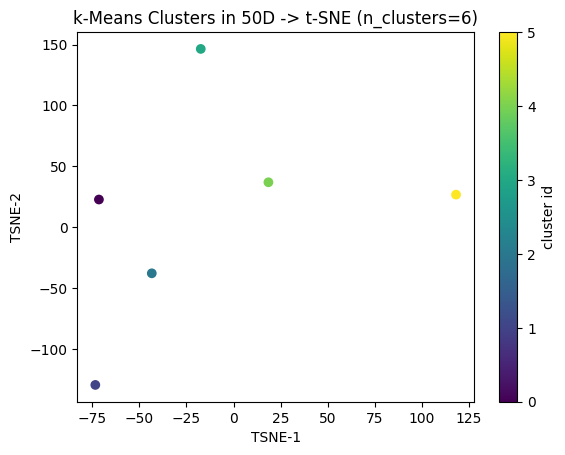

In [10]:
###########################################################
# Usage Example
###########################################################
if __name__ == "__main__":
    # Suppose we have 
    #  pca_path = "../models/pca_fit_base.pickle"  # a PCA(4096->50)
    #  kmeans_model_path = "../models/kmeans_base_50d.pkl"  # KMeans in 50D
    #  encoder_path = "../models/label_encoder.pickle"
    pca_path = "../models/pca_fit_base.pickle"
    kmeans_model_path = "../models/kmeans_base_50d.pickle"
    encoder_path = "../models/label_encoder.pickle"

    system = NoveltyDetectionSystem(pca_path, kmeans_model_path, encoder_path)

    # new batch of images
    batch_dir = Path("NEU_mixed_batch_40")
    batch_images = sorted(batch_dir.glob("*.bmp"))  # or any extension
    if not batch_images:
        print("[WARNING] No images found in NEU_mixed_batch_40!")
    else:
        print(f"Found {len(batch_images)} images in new batch")

    # 1) Extract 4096-D fc1 features
    batch_features = system.extract_features(batch_images)  # shape => (40,4096)

    # 2) Pass them to process_batch
    system.process_batch(batch_features)

    # 3) Visualize
    system.visualize_clusters()

    # Paths to pre-trained models
pca_path = "../models/pca_fit_base.pickle"
kmeans_path = "../models/kmeans_labeled_base.pickle"
encoder_path = "../models/label_encoder.pickle"

In [12]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def cluster_new_batch(new_data_50, old_centers_50, distance_threshold=8.0):
    """
    1) new_data_50: shape (40, 50)
       These 40 samples are already in 50D (after PCA).
    2) old_centers_50: shape (6, 50)
       The old 6 cluster centers from base data in 50D.
    3) distance_threshold=8.0  -> arbitrary cutoff to decide "old" vs. "new" cluster.

    Returns: 
      - new_kmeans_2: KMeans object for the 2 new clusters
      - cluster_mapping: list of length 2 describing each new cluster
                        e.g. "old class #2" or "new class"
    """

    # (A) cluster the 40 new samples into 2 clusters
    kmeans_2 = KMeans(n_clusters=2, random_state=42)
    kmeans_2.fit(new_data_50)

    # new_kmeans_2.cluster_centers_.shape => (2, 50)
    new_centers = kmeans_2.cluster_centers_

    cluster_mapping = []
    for i in range(2):
        # (B) measure distance of new_centers[i] to each old_center[j]
        dists = cdist([new_centers[i]], old_centers_50, metric="euclidean") 
        # shape => (1, 6)
        dists = dists[0]  # shape => (6,)
        min_idx = np.argmin(dists)
        min_dist = dists[min_idx]
        
        # (C) check if min_dist < threshold => same as old cluster?
        if min_dist < distance_threshold:
            # old class 
            cluster_mapping.append(f"old class {min_idx} (dist={min_dist:.2f})")
        else:
            # new class
            cluster_mapping.append(f"new class (dist={min_dist:.2f})")

    return kmeans_2, cluster_mapping




In [29]:
import numpy as np
import pickle
from sklearn.cluster import KMeans

# Suppose you have:
#  fc1 => shape (N, 4096)

# 1) Fit k-means
k = 6  # or however many clusters you want
kmeans_raw = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_raw.fit(fc1)

# 2) cluster_centers is shape => (k, 4096)
cluster_centers = kmeans_raw.cluster_centers_
print("Cluster centers shape:", cluster_centers.shape)

# 3) Optionally, save them
with open("kmeans_raw_fc1.pkl","wb") as f:
    pickle.dump(kmeans_raw, f)

# If you only want the center array:
with open("raw_cluster_centers.npy","wb") as f:
    np.save(f, cluster_centers)

print("Done! Found cluster centers in 4096D space.")


Cluster centers shape: (6, 4096)
Done! Found cluster centers in 4096D space.


In [13]:
# -----------------------------
# Example usage:
# -----------------------------
if __name__ == "__main__":
    # Suppose 'old_centers_50' is shape (6, 50). 
    # e.g. from: old_centers_50 = kmeans_old.cluster_centers_ 
    #           (where kmeans_old has n_clusters=6 in 50D).
    old_centers_50 = np.random.rand(6, 50) * 10.0  # dummy data
    
    # Suppose we have new_data_50 => shape (40, 50) after PCA
    new_data_50 = np.random.rand(40, 50) * 10.0    # dummy data

    new_kmeans_2, cluster_map = cluster_new_batch(new_data_50, old_centers_50, distance_threshold=8.0)
    print("New cluster centers => shape:", new_kmeans_2.cluster_centers_.shape)
    print("Cluster 0 =>", cluster_map[0])
    print("Cluster 1 =>", cluster_map[1])

    # The cluster_map might say e.g. "old class 3" or "new class"

New cluster centers => shape: (2, 50)
Cluster 0 => new class (dist=18.28)
Cluster 1 => new class (dist=20.63)
